# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import shutil

from benchmarks.utils import get_rus_revenue, is_better_solution, sns_line_plot
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.rm_dynamics import RailwayMarketDynamics
from src.entities import GSA

from pathlib import Path
from random import randint, seed
from robin.kernel.entities import Kernel
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply
from tqdm.notebook import tqdm

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
# Generator config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

  0%|          | 0/5 [00:00<?, ?it/s]

../data/supply_dummy.yml
../data/supply_dummy.yml
../data/supply_dummy.yml
../data/supply_dummy.yml
../data/supply_dummy.yml


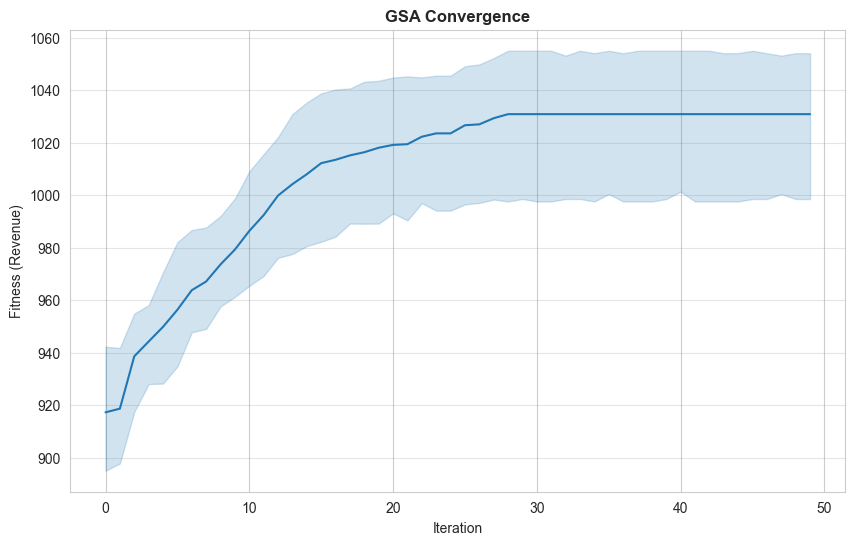

Mean: 0.3347s. - Std: 0.0369s.
{1060.7589893800791: <src.entities.Solution object at 0x14ffa8b80>, 1056.0: <src.entities.Solution object at 0x14fd5b610>, 1041.9265930340662: <src.entities.Solution object at 0x14fc84880>, 1027.8523266611871: <src.entities.Solution object at 0x14ffb6520>, 968.1500000000003: <src.entities.Solution object at 0x14f71c040>}


IsADirectoryError: [Errno 21] Is a directory: '../data/output/robin/'

In [14]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path = Path(f'../data/supply_dummy.yml'),
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=robin_save_path,
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=5,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

../data/supply_gen_test.yml


  0%|          | 0/5 [00:00<?, ?it/s]

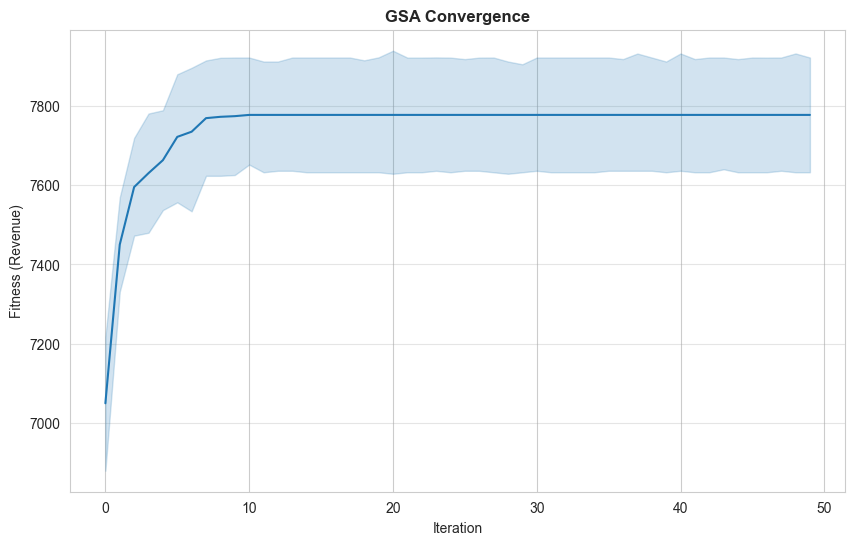

Mean: 10.1839s. - Std: 0.0467s.
{8000.612849385301: <src.entities.Solution object at 0x150dcbf70>, 7914.65470605674: <src.entities.Solution object at 0x16e2d8e80>, 7778.2764147624885: <src.entities.Solution object at 0x1577650d0>, 7605.410722519011: <src.entities.Solution object at 0x157a622b0>, 7586.499529862087: <src.entities.Solution object at 0x15780ad90>}
##################################################
	Improved solution: {'IRYO': 90764.53, 'OUIGO': 94974.85, 'Renfe AVE': 79798.94, 'Renfe AVLO': 38219.31}
	File: supply_test
##################################################


In [18]:
seed(21) # Master seed

# GSA parameters
runs = 5
pop_size = 20
iters = 50

best_solution = {}  # Best solution found

i = 'test'

# Generate random RU's service requests
generator = ServiceGenerator(supply_config_path=supply_config_path)

generator_seed = randint(1, 1000)
req_file_name = f'supply_gen_{i}'
generator.generate(file_name=Path(f'../data/{req_file_name}.yml'),
                              path_config=generator_config_path,
                              n_services=50,
                              seed=generator_seed)

# Get optimized & feasible timetable
print(f'../data/{req_file_name}.yml')

global_train_hist = pd.DataFrame()

runs_best_solution_history = {}
for r in tqdm(range(1, runs+1)):
    sm = RevenueMaximization(Path(f'../data/{req_file_name}.yml'), safe_headway=10)
    
    gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                   is_feasible=sm.feasible_services_times,
                   custom_repair=sm.custom_repair,
                   r_dim=len(sm.boundaries.real),
                   d_dim=0,
                   boundaries=sm.boundaries)
        
    training_history = gsa_algo.optimize(population_size=pop_size,
                                         iters=iters,
                                         chaotic_constant=False,
                                         repair_solution=True,
                                         initial_population=sm.get_initial_population(pop_size),
                                         verbose=False)
    training_history.insert(0, "run", r)
    global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
    
    runs_best_solution_history[sm.best_revenue] = sm.best_solution

# GSA Convergence plot
sns_line_plot(df=global_train_hist,
              x_data="Iteration",
              y_data="Fitness",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)")

# Execution time (mean and std.)
run_times = global_train_hist.groupby('run')['ExecutionTime'].last()
print(f'Mean: {round(run_times.mean(), 4)}s. - Std: {round(run_times.std(), 4)}s.')

runs_best_solution_history = dict(sorted(runs_best_solution_history.items(), key=lambda x: x[0], reverse=True))
print(runs_best_solution_history)
gsa_solution = tuple(runs_best_solution_history.values())[min(0, runs//2 - 1)]

services = sm.update_supply(path=Path(f'../data/{req_file_name}.yml'),
                            solution=gsa_solution)

tt_file_name = f'supply_{i}'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Simulate market
path_config_supply = f'{supply_save_path}{tt_file_name}.yml'
path_config_demand = '../configs/demand/demand.yml'
path_output_csv = f'{robin_save_path}output_{i}.csv'

if not Path(path_output_csv).parent.exists():
    Path(path_output_csv).parent.mkdir(parents=True)
    
kernel = Kernel(path_config_supply, path_config_demand)
services = kernel.simulate(output_path=path_output_csv, departure_time_hard_restriction=True)

# Evaluation
df = pd.read_csv(path_output_csv)
supply = Supply.from_yaml(path_config_supply)

rus_revenue = get_rus_revenue(supply, df)

if is_better_solution(rus_revenue, best_solution):
    best_solution = rus_revenue
    print("#"*50)
    print(f'\tImproved solution: {best_solution}')
    print(f'\tFile: {tt_file_name}')
    print("#"*50)

In [5]:
training_history

,run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,3,0,1757.352765,0,0.005882,[],"[987, 866, 944, 1023, 848, 869, 924, 1004, 107..."
1,3,1,1852.168031,0,0.029258,[],"[987.0, 869.0, 949.0, 1025.0, 839.0, 857.0, 92..."
2,3,2,1858.302868,0,0.051616,[],"[991, 870, 952, 1027, 838, 855, 926, 1003, 107..."
3,3,3,1868.495970,0,0.074046,[],"[994.0, 872.0, 951.0, 1028.0, 840.0, 860.0, 92..."
4,3,4,1868.495970,0,0.096575,[],"[994.0, 872.0, 951.0, 1028.0, 840.0, 860.0, 92..."
5,3,5,1871.882006,0,0.116776,[],"[994.0, 873.0, 951.0, 1029.0, 842.0, 856.0, 92..."
6,3,6,1871.882006,0,0.137095,[],"[994.0, 873.0, 951.0, 1029.0, 842.0, 856.0, 92..."
7,3,7,1890.743316,0,0.157359,[],"[993.0, 872.0, 952.0, 1028.0, 841.0, 860.0, 92..."
8,3,8,1895.454559,0,0.177412,[],"[993.0, 872.0, 952.0, 1028.0, 841.0, 859.0, 92..."
9,3,9,1895.454559,0,0.196812,[],"[993.0, 872.0, 952.0, 1028.0, 841.0, 859.0, 92..."


In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0
